# Difftest Results

Connect to results database:

In [2]:
import db
from db import *
%run util.py

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [3]:
import pandas as pd

session = db.make_session()

TABLE_NAMES = ["CLSmith", "CLgen", "CLgen w. cl_launcher", "CLgen w. co"]
TABLES = [CLSmithResult, CLgenResult, cl_launcherCLgenResult, coCLgenResult]

data = [
    ("#. Programs", [session.query(t.program_id).group_by(t.program_id).count() for t in TABLES]),
    ("#. Testbeds", [session.query(t.testbed_id).group_by(t.testbed_id).count() for t in TABLES]),
    ("#. Params", [session.query(t.params_id).group_by(t.params_id).count() for t in TABLES]),
    ("#. Results", [session.query(t).count() for t in TABLES]),
]
i, d = zip(*data)
overview = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
overview

,CLSmith,CLgen,CLgen w. cl_launcher,CLgen w. co
#. Programs,10500,33329,2385,3385
#. Testbeds,11,10,7,7
#. Params,4,6,4,4
#. Results,342943,650840,66780,53840


# Experimental Setup

### TestBeds

A testbed is a combination of host platform and OpenCL device.

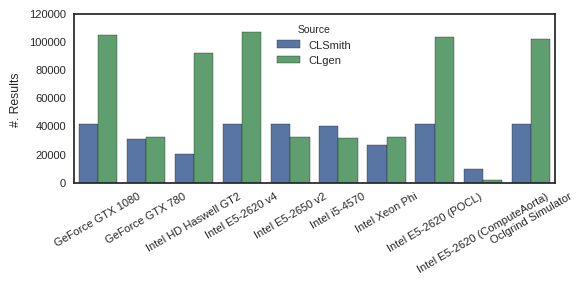

In [3]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from labm8 import viz

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

def get_testbed_info(config_id, testbed_id, source, results_table):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    num_results = session.query(results_table).filter(results_table.testbed_id == testbed_id).count()
    return {
        "Device": device_str(testbed.device),
        "#. Results": num_results,
        "Source": source,
    }

data = []
for source, table in [("CLSmith", CLSmithResult), ("CLgen", CLgenResult)]:
    data += [get_testbed_info(*x, source, table) for x in CONFIGURATIONS]
ax = sns.barplot(x="Device", y="#. Results", hue="Source", data=pd.DataFrame(data))
plt.xlabel("")
plt.ylabel("#. Results")
plt.setp(ax.get_xticklabels(), rotation=30)  # rotate x ticks
viz.finalise(figsize=(6, 3))

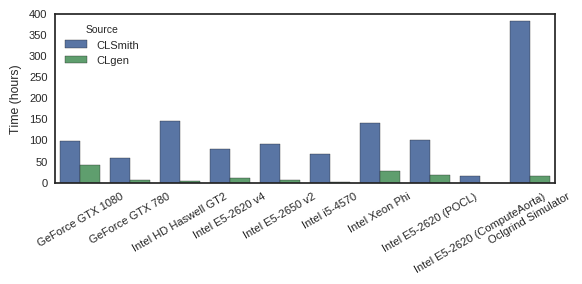

In [4]:
def get_testbed_info(config_id, testbed_id, source, results_table, program_table, reduction_table, harness_table=None):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    total_time = session.query(sql.sql.func.sum(results_table.runtime))\
        .filter(results_table.testbed_id == testbed_id).first()[0] or 0
    total_time += session.query(sql.sql.func.sum(reduction_table.runtime))\
        .join(results_table)\
        .filter(results_table.testbed_id == testbed_id).first()[0] or 0
    return {
        "Device": device_str(testbed.device),
        "Test Time": total_time / 3600,
        "Source": source,
    }

data = []
for row in [("CLSmith", CLSmithResult, CLSmithProgram, CLSmithReduction), 
                       ("CLgen", CLgenResult, CLgenProgram, CLgenReduction, CLgenHarness)]:
    data += [get_testbed_info(*x, *row) for x in CONFIGURATIONS]
ax = sns.barplot(x="Device", y="Test Time", hue="Source", data=pd.DataFrame(data))
plt.xlabel("")
plt.ylabel("Time (hours)")
plt.setp(ax.get_xticklabels(), rotation=30)  # rotate x ticks
# ax.set_yscale("log", nonposy='clip')
viz.finalise(figsize=(6, 3))

In [4]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase

import os
from collections import OrderedDict


def get_platform_stats(testbed: Testbed):
    submitable_results = [coCLgenResult, cl_launcherCLgenResult, CLgenResult]
    
    def get_submitted(table):
        """ submitted, non-duplicate bugs """
        return session.query(table)\
            .filter(table.testbed_id == testbed.id,
                    table.submitted,
                    table.dupe != 1).count()

    def get_generated(table):
        return session.query(table)\
            .filter(table.testbed_id == testbed.id,
                    sql.or_(table.submitted, table.dupe)).count()

    runtime_tables = [coCLgenResult, CLgenResult, cl_launcherCLgenResult]
    def get_runtime(table):
        return session.query(sql.sql.func.sum(table.runtime)).filter(table.testbed_id == testbed.id).first()[0] or 0

    return (
        sum(get_generated(table) for table in submitable_results), 
        sum(get_submitted(table) for table in submitable_results),
        sum(get_runtime(table) for table in runtime_tables),
    )


def get_row(config_id, testbed_id):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    d = OrderedDict()
    d["#."] = config_id
    d["Platform"] = platform_str(testbed.platform)
    d["Device"] = device_str(testbed.device)
    d["Driver"] = driver_str(testbed.driver)
    d["OpenCL"] = testbed.opencl
    d["Operating system"] = host_str(testbed.host)
    d["Device type"] = devtype_str(testbed.devtype)
    generated, submitted, runtime = get_platform_stats(testbed)
    d["Testing time"] = "{:.0f}h".format(round(runtime / 3600))
    d["B.R. Generated"] = generated
    d["B.R. Submitted"] = submitted
    return d


rows = [get_row(*x) for x in CONFIGURATIONS]
table = pd.DataFrame(rows)
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    print(f"""\
\\begin{{tabular}}{{ clllllll | ll }}
\\toprule
 & & & & & & & & \\multicolumn{{2}}{{c}}{{\\textbf{{Bug Reports}}}} \\\\
\\textbf{{\\#. }} & \\textbf{{Platform}} & \\textbf{{Device}} & \\textbf{{Driver}} & \\textbf{{OpenCL}} & 
\\textbf{{Operating system}} & \\textbf{{Device Type}} & \\textbf{{Testing time}} &
\\textbf{{Generated}} & \\textbf{{Submitted}} \\\\
\\midrule""", file=outfile)
    for row in rows:
        print(" & ".join([str(x) for x in row.values()]), "\\\\", file=outfile)
    print(f"""
\\bottomrule
\\end{{tabular}}
""", file=outfile)

!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

Current branch master is up to date.
[master 473dfaa] auto: build/tab/platforms.tex
 1 file changed, 9 insertions(+), 9 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 501 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   8ea2646..473dfaa  master -> master


,#.,Platform,Device,Driver,OpenCL,Operating system,Device type,Testing time,B.R. Generated,B.R. Submitted
0,1,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 64bit,GPU,50h,57,0
1,2,NVIDIA CUDA,GeForce GTX 780,361.42,1.2,openSUSE 13.1 64bit,GPU,6h,24,0
2,3,Intel Gen OCL Driver,Intel HD Haswell GT2,1.3,1.2,Ubuntu 16.04 64bit,GPU,4h,276,0
3,4,Intel OpenCL,Intel E5-2620 v4,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU,17h,1749,0
4,5,Intel OpenCL,Intel E5-2650 v2,1.2.0.44,1.2,CentOS 7.1 64bit,CPU,13h,923,0
5,6,Intel OpenCL,Intel i5-4570,1.2.0.25,1.2,Ubuntu 16.04 64bit,CPU,4h,446,0
6,7,Intel OpenCL,Intel Xeon Phi,1.2,1.2,CentOS 7.1 64bit,Accelerator,36h,81,0
7,8,POCL,Intel E5-2620 (POCL),0.14,2.0,Ubuntu 16.04 64bit,CPU,24h,2017,0
8,9,ComputeAorta,Intel E5-2620 (ComputeAorta),1.14,1.2,Ubuntu 16.04 64bit,CPU,0h,0,0
9,10,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 64bit,Emulator,23h,4495,0


In [6]:
%run mkmegatable.ipy

insufficient CLgenResults for GeForce GTX 1080 True (32.2 hs)
insufficient CLgenResults for GeForce GTX 1080 False (36.2 hs)
insufficient CLSmithResults for GeForce GTX 780 True (41.8 hs)
insufficient CLgenResults for GeForce GTX 780 True (7.5 hs)
insufficient CLSmithResults for GeForce GTX 780 False (40.2 hs)
insufficient CLgenResults for GeForce GTX 780 False (7.1 hs)
insufficient CLgenResults for Intel HD Haswell GT2 True (15.4 hs)
insufficient CLgenResults for Intel HD Haswell GT2 False (11.3 hs)
insufficient CLgenResults for Intel E5-2620 v4 True (17.8 hs)
insufficient CLgenResults for Intel E5-2620 v4 False (20.0 hs)
insufficient CLgenResults for Intel E5-2650 v2 True (7.6 hs)
insufficient CLgenResults for Intel E5-2650 v2 False (7.7 hs)
insufficient CLSmithResults for Intel i5-4570 True (46.6 hs)
insufficient CLgenResults for Intel i5-4570 True (5.7 hs)
insufficient CLgenResults for Intel i5-4570 False (5.6 hs)
insufficient CLgenResults for Intel Xeon Phi True (18.5 hs)
insuffic

Current branch master is up to date.
[master 88782d7] auto: build/tab: Megatables
 1 file changed, 8 insertions(+), 8 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 661 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   6da5781..88782d7  master -> master


## Runtimes

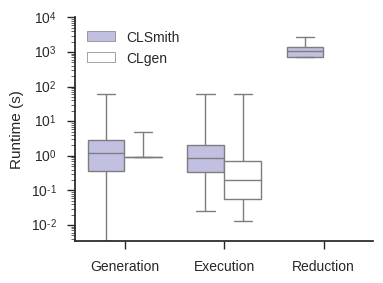

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/runtimes.pdf
[master eeaeaa2] auto: build/img/runtimes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 2.67 KiB | 0 bytes/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   88782d7..eeaeaa2  master -> master


In [ ]:
sns.set(style="ticks")

def plot_runtimes(*args, **kwargs):
    TIMEOUT = 60
    
    # CLSmith times
    q = session.query(
            CLSmithResult.runtime, 
            CLSmithProgram.runtime, 
            sql.sql.func.ifnull(CLSmithReduction.runtime, 0))\
        .outerjoin(CLSmithProgram)\
        .outerjoin(CLSmithReduction)\
        .filter(CLSmithResult.classification != None)
    clsmith_times = np.array([row for row in q])
    
    # CLgen times
    q = session.query(
            CLgenResult.runtime,
            sql.sql.func.ifnull(CLgenProgram.runtime, clgen_generation_time) + CLgenHarness.generation_time,
            sql.sql.func.ifnull(CLgenReduction.runtime, 0))\
        .outerjoin(CLgenProgram)\
        .outerjoin(CLgenHarness)\
        .outerjoin(CLgenReduction)\
        .filter(CLgenResult.classification != None)
    clgen_times = np.array([row for row in q])

    table = (
        [("Execution", x, "CLSmith") for x in clsmith_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLSmith") for x in clsmith_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLSmith") for x in clsmith_times[:,2] if x > 0] +
        [("Execution", x, "CLgen") for x in clgen_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLgen") for x in clgen_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLgen") for x in clgen_times[:,2] if x > 0])
    table = pd.DataFrame(table, columns=["Name", "Runtime (s)", "Source"])

    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution", "Reduction"])

    
       # Y axis
    ax.set_yscale("log", nonposy='clip')
    plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)

    viz.finalise(*args, **kwargs)


plot_runtimes(figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_runtimes(fs.path("~/docs/paper-project_b/build/img/runtimes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/runtimes.pdf" && git push

## Kernel sizes

In [ ]:
sns.set(style="ticks")
from collections import defaultdict

def get_kernel_sizes():
    TIMEOUT = 60
    
    # CLSmith times
    clsmith = session.query(
            CLSmithResult.classification,
            sql.sql.func.ifnull(CLSmithReduction.src, CLSmithProgram.src))\
        .outerjoin(CLSmithProgram)\
        .outerjoin(CLSmithReduction)\
        .filter(CLSmithResult.classification != None)#,
#                CLSmithResult.classification != "pass")
    
    clgen = session.query(
            CLgenResult.classification,
            sql.sql.func.ifnull(CLgenReduction.src, CLgenProgram.src))\
        .outerjoin(CLgenProgram)\
        .outerjoin(CLgenReduction)\
        .filter(CLgenResult.classification != None),
#                CLgenResult.classification != "pass")
    
    table = (
        [(classification, len(src.split('\n')), "CLSmith") for classification, src in clsmith] +
        [(classification, len(src.split('\n')), "CLgen") for classification, src in clgen])
    
    return pd.DataFrame(table, columns=['Classification', 'Line count', 'Source'])

table = get_kernel_sizes()

In [ ]:
def plot_kernel_sizes(table, *args, **kwargs):
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Line count", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["w", "bf", "to"])

    # Y axis
    ax.set_yscale("log", nonposy='clip')
    # plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)
    
    viz.finalise(*args, **kwargs)
    
plot_kernel_sizes(table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_kernel_sizes(table, fs.path("~/docs/paper-project_b/build/img/kernel-sizes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/kernel-sizes.pdf" && git push

## Total time

In [ ]:
def get_totaltimes():

    def _t(results_table, programs_table, reductions_table):
        generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
        runtime = results_table.runtime
        reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)
        total_time = generation_time + runtime + reduction_time

        q = session.query(total_time)\
            .outerjoin(programs_table)\
            .outerjoin(reductions_table)\
            .filter(results_table.classification != None)\
            .order_by(results_table.date)

        times = np.array([row[0] / 3600 for row in q]).cumsum()
        return times
    
    return (
        _t(CLSmithResult, CLSmithProgram, CLSmithReduction),
        _t(CLgenResult, CLgenProgram, CLgenReduction)
    )

clsmith_times, clgen_times = get_totaltimes()

In [ ]:
from matplotlib.ticker import FuncFormatter


def plot_total_tests(clsmith_times, clgen_times, *args, **kwargs):
    
    def thousands(x, pos):
        return "{:.0f}k".format(x / 1000)
    
    ax = plt.gca()
    ax.plot(clsmith_times, range(len(clsmith_times)), label="CLSmith")
    ax.plot(clgen_times, range(len(clgen_times)), label="CLgen")

    ax.set_xlabel("Testing time (hours)")
    ax.set_ylabel("Completed Test cases")
    
    # X axis
    ax.set_xlim((0, 48))
    
    # Y axis
    formatter = FuncFormatter(thousands)
    ax.set_ylim((0, 100000))
    ax.yaxis.set_major_formatter(formatter)
    
    ax.legend()
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
        
    viz.finalise(*args, **kwargs)

plot_total_tests(clsmith_times, clgen_times, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_total_tests(clsmith_times, clgen_times, fs.path("~/docs/paper-project_b/build/img/total-tests.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/total-tests.pdf" && git push